In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [6]:
train_clientes = pd.read_csv('_data/train_clientes.csv')
train_requerimientos = pd.read_csv('_data/train_requerimientos.csv')
test_clientes = pd.read_csv('_data/test_clientes.csv')
test_requerimientos = pd.read_csv('_data/test_requerimientos.csv')

In [7]:
train = pd.read_csv('_data/train_preprocessed.csv')
test = pd.read_csv('_data/test_preprocessed.csv')

In [8]:
results = pd.read_csv('_data/results.csv')

In [9]:
results

,model,accuracy,accuracy-std,f1-score,f1-score-std,aucroc,aucroc-std,logloss,logloss-std,time
0,XGBClassifier,0.872071,0.000393,0.413881,0.004304,0.635150,0.002001,4.418511,0.013572,24861
1,LGBMClassifier,0.876386,0.001123,0.481487,0.007929,0.670094,0.005204,4.269507,0.038777,1674
2,CatBoostClassifier,0.879357,0.000520,0.482438,0.006846,0.668718,0.003847,4.166874,0.017965,144761
3,TESTING_PARAMS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,XGBClassifier,0.880171,0.000859,0.484674,0.003495,0.669501,0.002300,4.138749,0.029675,31504
5,XGBClassifier,0.874900,0.001844,0.535230,0.003263,0.707799,0.001611,4.320834,0.063708,113529


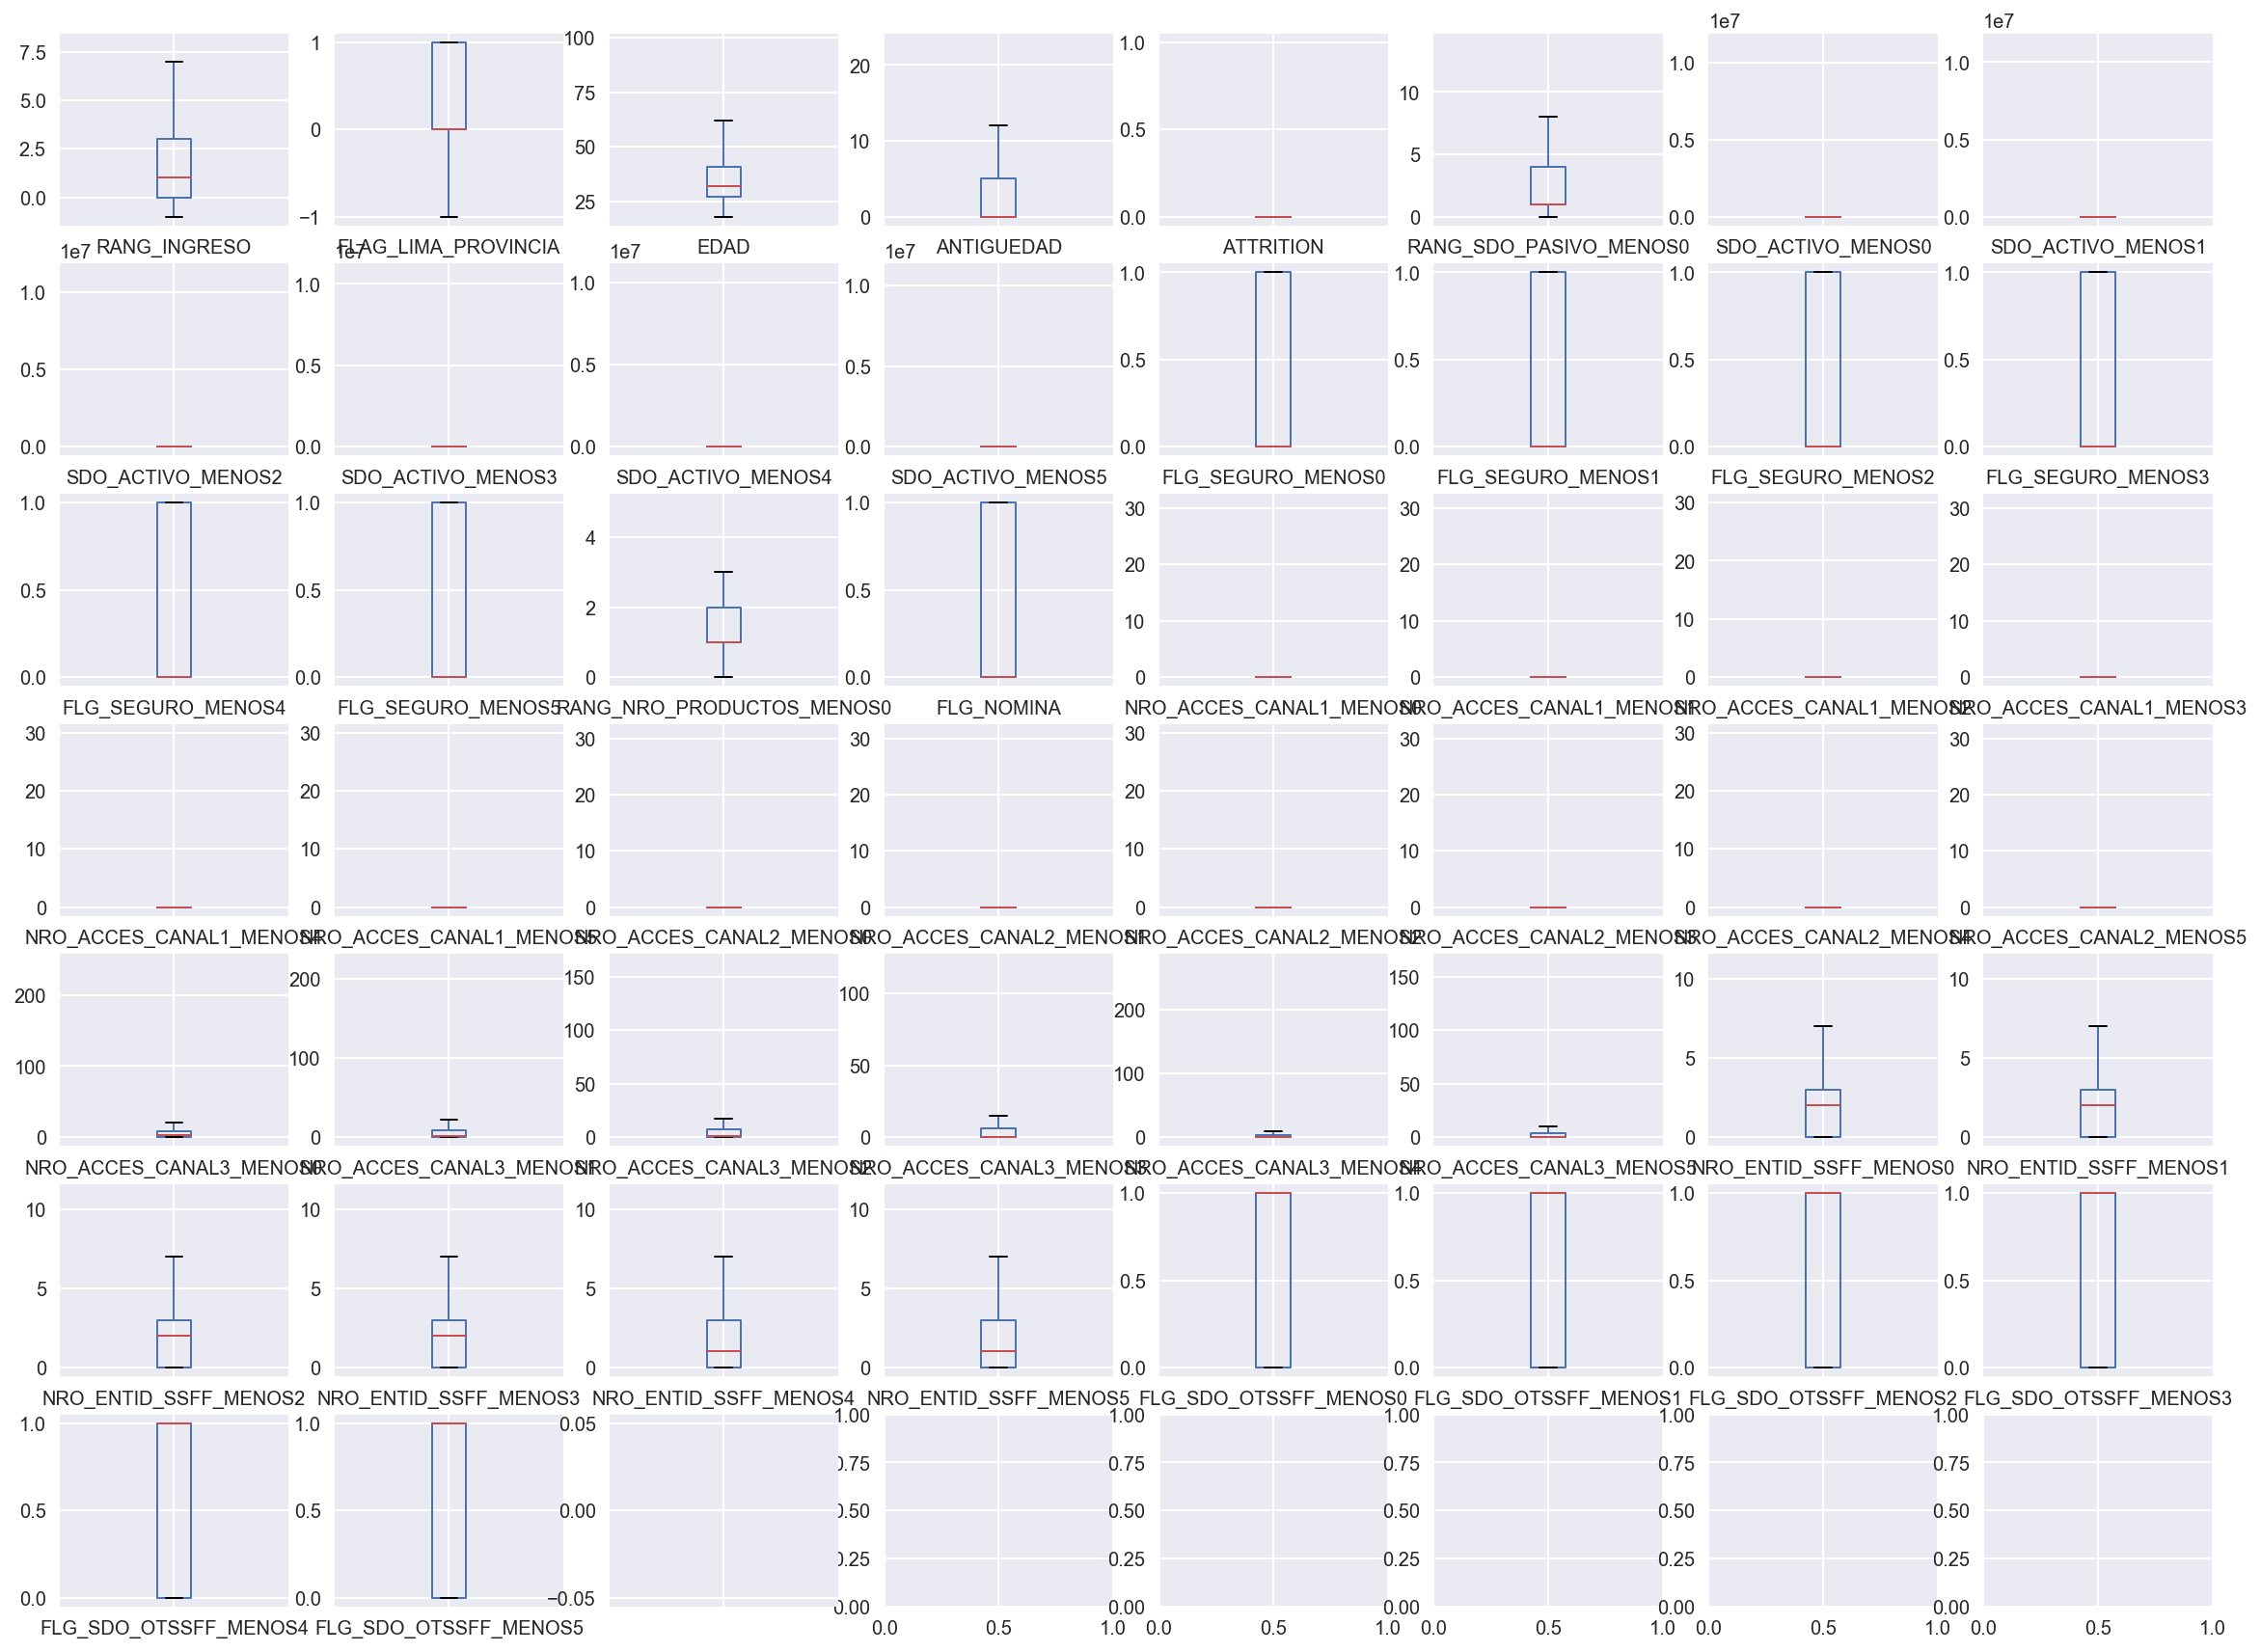

In [54]:
plt.subplots(nrows=7, ncols=8, figsize=(20, 15))
for i in range(1,52):
    plt.subplot(7, 8, i)
    train.drop('ID_CORRELATIVO', axis=1).iloc[:,i:i+1].boxplot()

## Preprocessing

In [10]:
# Hay solo un nulo en:
# DICTAMEN (1 / 51417)
# train_requerimientos.info()

# LabelEncode TIPO_REQUERIMIENTO2: Reclamo / Solicitud                     (CAT) groupby count each cat
# Encode DICTAMEN: NO PROCEDE / PROCEDE TOTAL / PROCEDE PARCIAL *          (CAT) groupby count each cat *
# Parse and encode PRODUCTO_SERVICIO_2: Producto 01 - Producto 23 (22, 20) (CAT) groupby count each cat
# Parse and encode SUBMOTIVO_2: Submotivo 05 - Submotivo 160 (85, 81)      (CAT ord?) 
# Parse CODMES: 201203 - 201208                                            (NUM) groupby count each cat
#### train_requerimientos.head(2)

In [153]:
full_requerimientos = pd.concat((train_requerimientos, test_requerimientos))

In [ ]:
groups = train_requerimientos.groupby('ID_CORRELATIVO')
train_grouped = pd.DataFrame(index=groups.agg('count').index)
for col in ['TIPO_REQUERIMIENTO2', 'DICTAMEN', 'PRODUCTO_SERVICIO_2', 'CODMES']:
    for cat in full_requerimientos[col].dropna().unique():
        train_grouped[f'{col}-{cat}'] = groups[col].apply(lambda x: len(x[x==cat]))

In [ ]:
groups = test_requerimientos.groupby('ID_CORRELATIVO')
test_grouped = pd.DataFrame(index=groups.agg('count').index)
for col in ['TIPO_REQUERIMIENTO2', 'DICTAMEN', 'PRODUCTO_SERVICIO_2', 'CODMES']:
    for cat in full_requerimientos[col].dropna().unique():
        test_grouped[f'{col}-{cat}'] = groups[col].apply(lambda x: len(x[x==cat]))

In [158]:
train_grouped.to_csv('_data/train_grouped.csv')
test_grouped.to_csv('_data/test_grouped.csv')

In [161]:
train_grouped = pd.read_csv('_data/train_grouped.csv')
test_grouped = pd.read_csv('_data/test_grouped.csv')

In [167]:
train.shape, train_grouped.shape

((70000, 52), (35026, 34))

In [168]:
train = pd.merge(train, train_grouped, how='left', on='ID_CORRELATIVO')

In [170]:
test = pd.merge(test, test_grouped, how='left', on='ID_CORRELATIVO')

In [172]:
train.shape, train_grouped.shape, test.shape, test_grouped.shape

((70000, 85), (35026, 34), (30000, 84), (14974, 34))

In [174]:
train.to_csv('_data/train_merge.csv', index=False)
test.to_csv('_data/test_merge.csv', index=False)

## Checkpoint

In [175]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import time
import winsound

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
from sklearn.model_selection import StratifiedKFold

In [187]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [188]:
def run_model(model, X, y):
    model_name = str(model.__class__).split('.')[-1].replace('>','').replace("'",'')
    print(model_name)
    accuracy = []
    f1 = []
    auc = []
    logloss = []
    start = int(time.time() * 1000)
    for train_idx, test_idx in kfolds.split(X, y):
        model.fit(X.iloc[train_idx,:], y[train_idx])
        y_ = model.predict(X.iloc[test_idx,:])
        accuracy += [accuracy_score(y.iloc[test_idx], y_)]
        f1 += [f1_score(y.iloc[test_idx], y_)]
        auc += [roc_auc_score(y.iloc[test_idx], y_)]
        logloss += [log_loss(y.iloc[test_idx], y_)]
    end = int(time.time() * 1000)
    results.loc[len(results)] = [model_name, np.mean(accuracy), np.std(accuracy), 
                                 np.mean(f1), np.std(f1),
                                 np.mean(auc), np.std(auc), 
                                 np.mean(logloss), np.std(logloss), str(end - start)]
    winsound.Beep(2500, 1000)

In [179]:
results.loc[len(results)] = ['FULL_DATASET'] + [0] * 9
results

,model,accuracy,accuracy-std,f1-score,f1-score-std,aucroc,aucroc-std,logloss,logloss-std,time
0,XGBClassifier,0.872071,0.000393,0.413881,0.004304,0.635150,0.002001,4.418511,0.013572,24861
1,LGBMClassifier,0.876386,0.001123,0.481487,0.007929,0.670094,0.005204,4.269507,0.038777,1674
2,CatBoostClassifier,0.879357,0.000520,0.482438,0.006846,0.668718,0.003847,4.166874,0.017965,144761
3,TESTING_PARAMS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,XGBClassifier,0.880171,0.000859,0.484674,0.003495,0.669501,0.002300,4.138749,0.029675,31504
5,XGBClassifier,0.874900,0.001844,0.535230,0.003263,0.707799,0.001611,4.320834,0.063708,113529
6,FULL_DATASET,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [180]:
run_model(XGBClassifier(), train.drop(['ID_CORRELATIVO', 'ATTRITION'], axis=1), train['ATTRITION'])
results

XGBClassifier


,model,accuracy,accuracy-std,f1-score,f1-score-std,aucroc,aucroc-std,logloss,logloss-std,time
0,XGBClassifier,0.872071,0.000393,0.413881,0.004304,0.635150,0.002001,4.418511,0.013572,24861
1,LGBMClassifier,0.876386,0.001123,0.481487,0.007929,0.670094,0.005204,4.269507,0.038777,1674
2,CatBoostClassifier,0.879357,0.000520,0.482438,0.006846,0.668718,0.003847,4.166874,0.017965,144761
3,TESTING_PARAMS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,XGBClassifier,0.880171,0.000859,0.484674,0.003495,0.669501,0.002300,4.138749,0.029675,31504
5,XGBClassifier,0.874900,0.001844,0.535230,0.003263,0.707799,0.001611,4.320834,0.063708,113529
6,FULL_DATASET,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
7,XGBClassifier,0.872129,0.001760,0.411888,0.012084,0.634202,0.005446,4.416538,0.060778,186127


In [181]:
run_model(LGBMClassifier(), train.drop(['ID_CORRELATIVO', 'ATTRITION'], axis=1), train['ATTRITION'])
results

LGBMClassifier


,model,accuracy,accuracy-std,f1-score,f1-score-std,aucroc,aucroc-std,logloss,logloss-std,time
0,XGBClassifier,0.872071,0.000393,0.413881,0.004304,0.635150,0.002001,4.418511,0.013572,24861
1,LGBMClassifier,0.876386,0.001123,0.481487,0.007929,0.670094,0.005204,4.269507,0.038777,1674
2,CatBoostClassifier,0.879357,0.000520,0.482438,0.006846,0.668718,0.003847,4.166874,0.017965,144761
3,TESTING_PARAMS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,XGBClassifier,0.880171,0.000859,0.484674,0.003495,0.669501,0.002300,4.138749,0.029675,31504
5,XGBClassifier,0.874900,0.001844,0.535230,0.003263,0.707799,0.001611,4.320834,0.063708,113529
6,FULL_DATASET,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
7,XGBClassifier,0.872129,0.001760,0.411888,0.012084,0.634202,0.005446,4.416538,0.060778,186127
8,LGBMClassifier,0.877229,0.002107,0.474719,0.009287,0.665458,0.004575,4.240392,0.072760,9602


In [184]:
results.to_csv('_data/results.csv', index=None)

In [ ]:
run_model(CatBoostClassifier(), train.drop(['ID_CORRELATIVO', 'ATTRITION'], axis=1), train['ATTRITION'])
results

In [185]:
xgb = XGBClassifier()
xgb.fit(train.drop(['ID_CORRELATIVO', 'ATTRITION'], axis=1), train['ATTRITION'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [209]:
lgbm = LGBMClassifier()
lgbm.fit(train.drop(['ID_CORRELATIVO', 'ATTRITION'], axis=1), train['ATTRITION'])

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0.0, n_estimators=10, n_jobs=-1,
        num_leaves=31, objective=None, random_state=0, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=50000, subsample_freq=1)

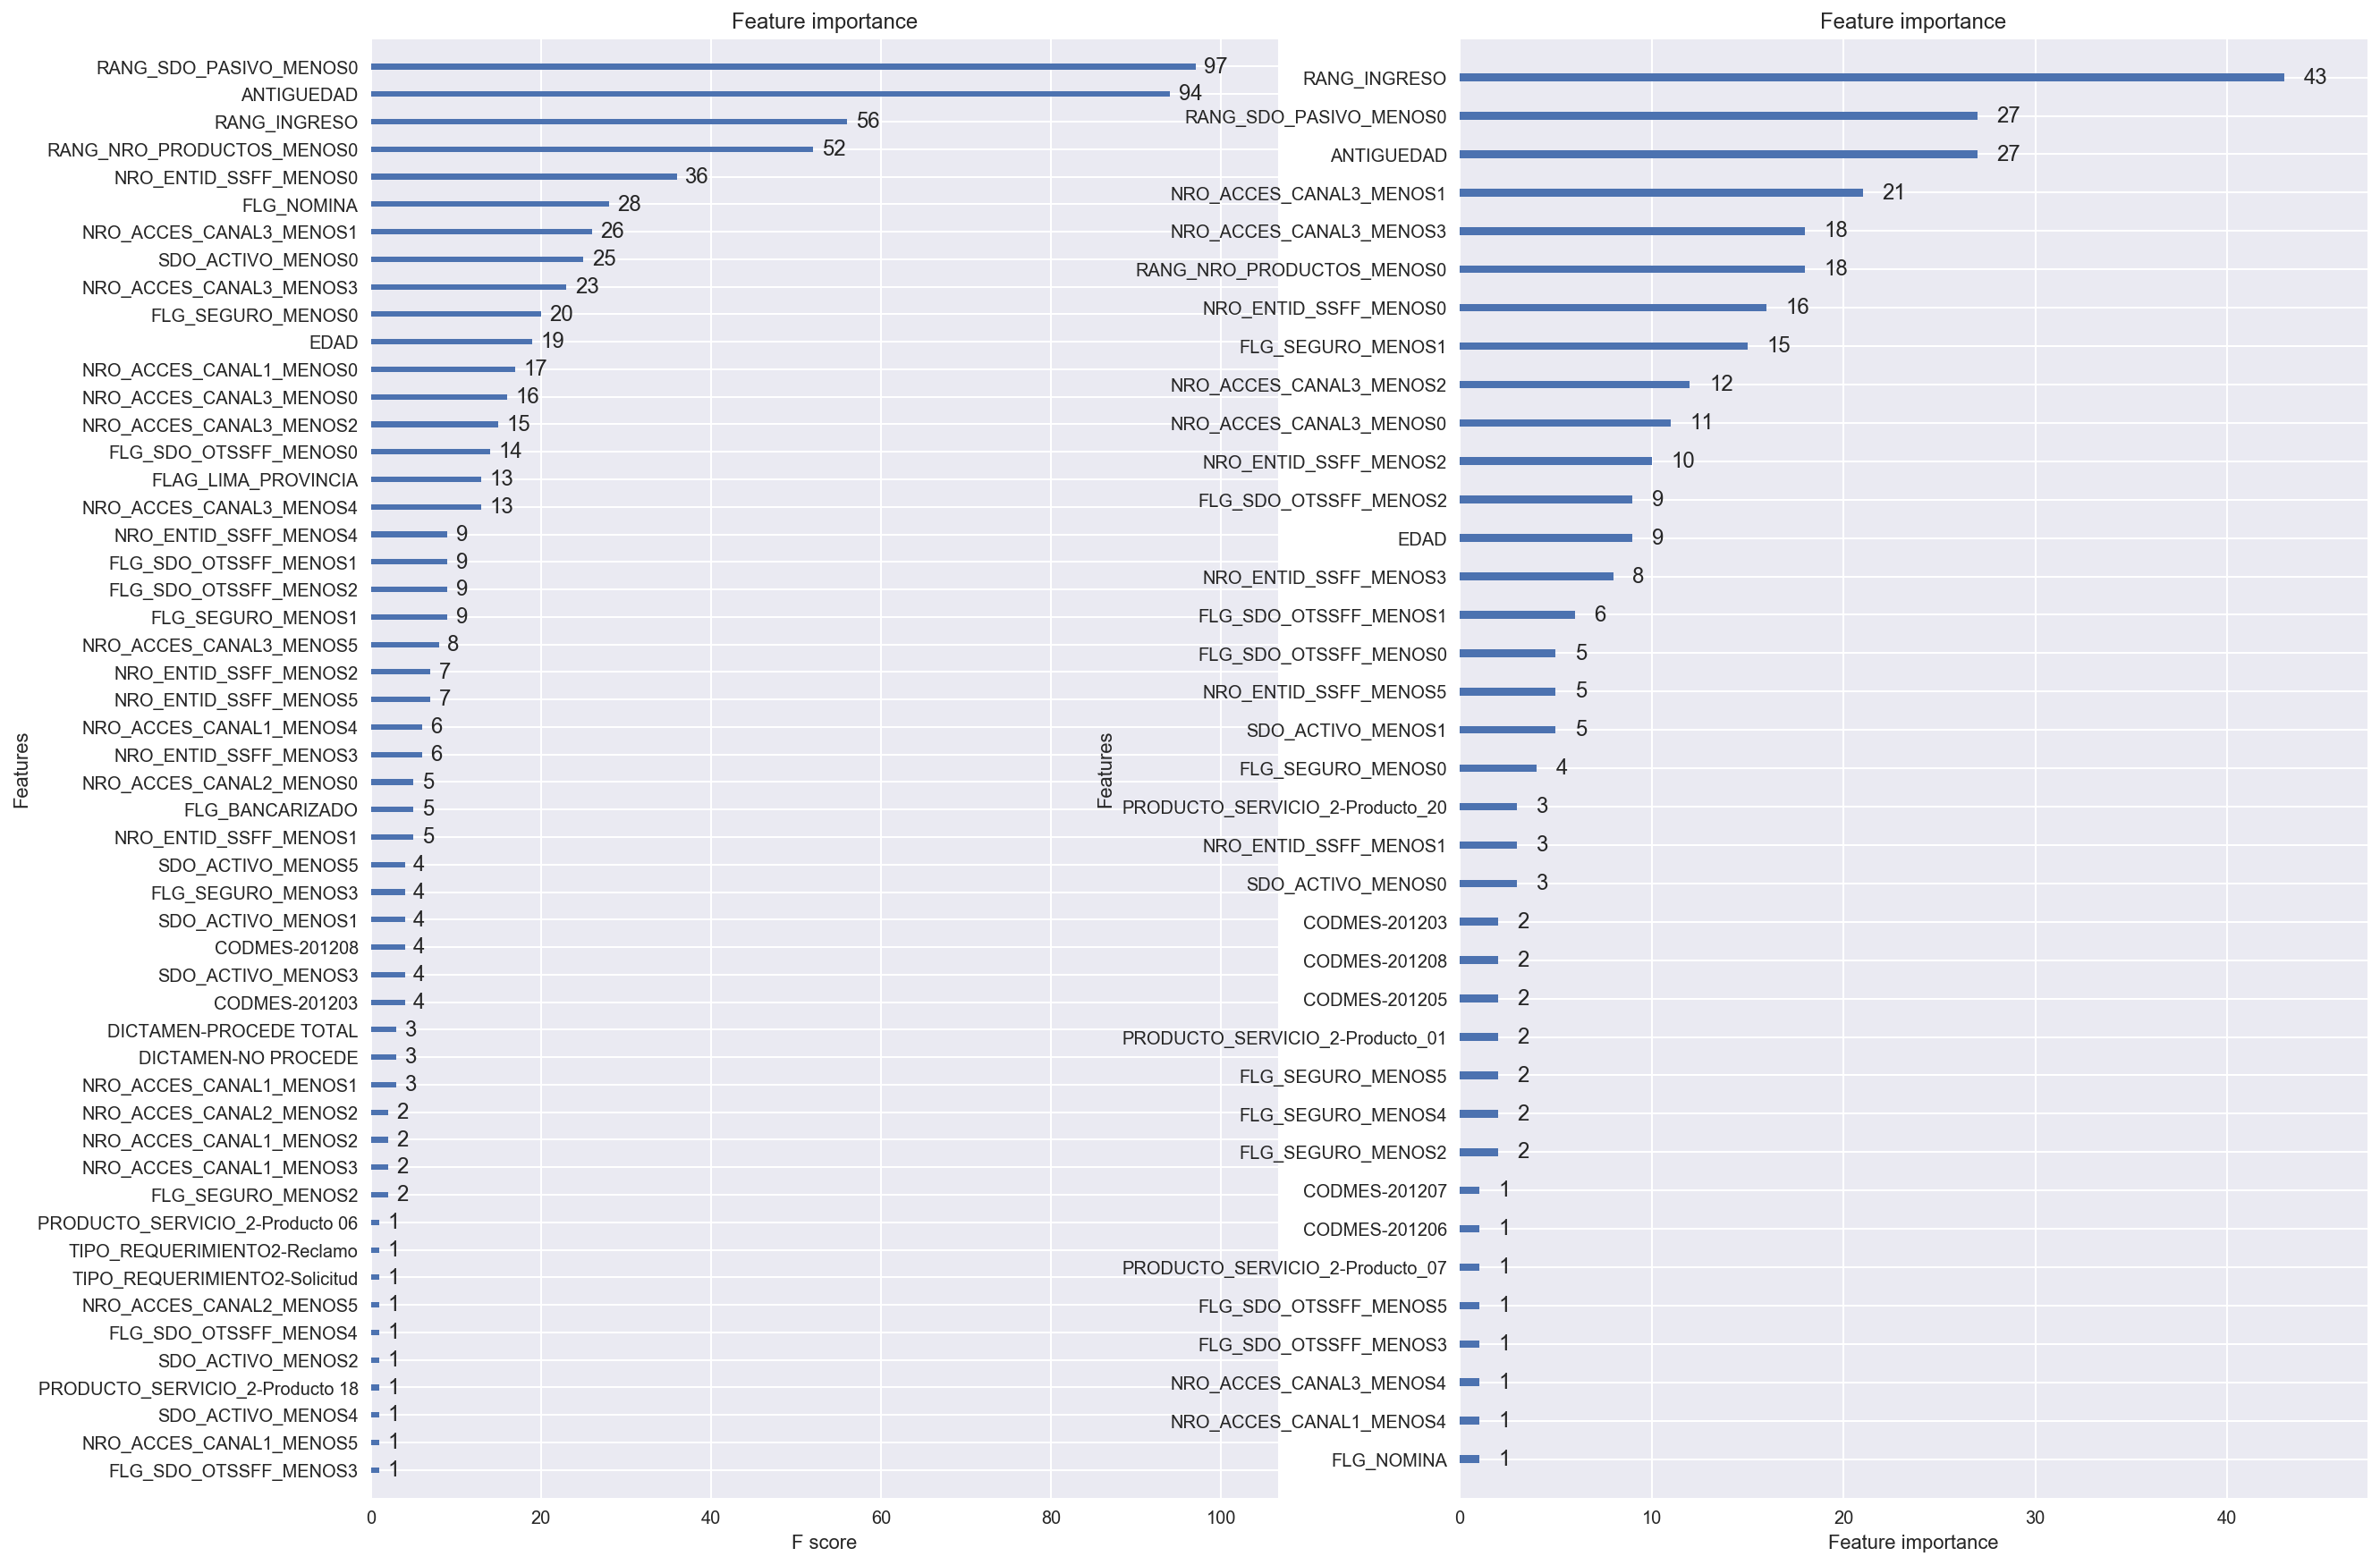

In [215]:
from xgboost import plot_importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))
plot_importance(xgb, ax=ax1)

from lightgbm import plot_importance
plot_importance(lgbm, ax=ax2)

## Next Steps

- Normalize dataset
- Remove outliers
- Tune parameters
- Feature importances